In [2]:
import os
import pandas as pd
import numpy as np


In [3]:
pd.set_option('display.max_columns', None)
path = '../../../../../archive/raw/HI-Small_Trans.csv'
df = pd.read_csv(path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


c:\Users\lee.eunjeong\.conda\envs\FDS4mula2\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


{'histograms': {'Timestamp': <Axes: >, 'From Bank': <Axes: >, 'Account': <Axes: >, 'To Bank': <Axes: >, 'Account.1': <Axes: >, 'Amount Received': <Axes: >, 'Amount Paid': <Axes: >, 'Is Laundering': <Axes: >, 'Receiving Currency_Australian Dollar': None, 'Receiving Currency_Bitcoin': None, 'Receiving Currency_Brazil Real': None, 'Receiving Currency_Canadian Dollar': None, 'Receiving Currency_Euro': None, 'Receiving Currency_Mexican Peso': None, 'Receiving Currency_Ruble': None, 'Receiving Currency_Rupee': None, 'Receiving Currency_Saudi Riyal': None, 'Receiving Currency_Shekel': None, 'Receiving Currency_Swiss Franc': None, 'Receiving Currency_UK Pound': None, 'Receiving Currency_US Dollar': None, 'Receiving Currency_Yen': None, 'Receiving Currency_Yuan': None, 'Payment Currency_Australian Dollar': None, 'Payment Currency_Bitcoin': None, 'Payment Currency_Brazil Real': None, 'Payment Currency_Canadian Dollar': None, 'Payment Currency_Euro': None, 'Payment Currency_Mexican Peso': None, '

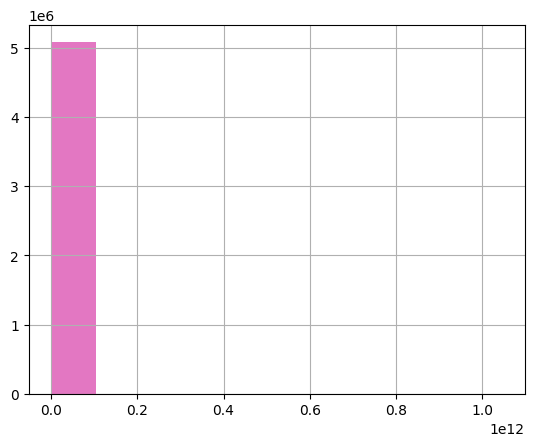

In [ ]:
#### 원핫 인코딩과, 라벨인코딩으로 통계정보를 도출 할수 있도록 컬럼들을 변환.

# 1. Timestamp 컬럼을 datetime 객체로 변환 (errors='coerce' 옵션 사용)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M', errors='coerce')

# 1-1. 'Timestamp' 컬럼에서 NaT인 값 (변환 실패한 값)을 NaN으로 대체
df['Timestamp'] = df['Timestamp'].replace({pd.NaT: np.nan})

# 2. 결측치 처리 (NaN 값을 삭제 또는 대체)
df = df.dropna(subset=['Timestamp'])

# 3. DataFrame이 비어있는지 확인
if df.empty:
    print("DataFrame is empty after removing rows with missing Timestamp values.")
    # 이후 코드를 실행하지 않도록 처리 (예: return)
    exit()

# 4. datetime 객체를 Unix timestamp로 변환
df['Timestamp'] = df['Timestamp'].astype('int64') // 10**9

# (선택 사항) 필요에 따라 스케일링 또는 정규화를 수행
# 예: MinMaxScaler를 사용하여 0과 1 사이의 값으로 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Timestamp'] = scaler.fit_transform(df[['Timestamp']])

# 5. Object 타입 컬럼 원핫 인코딩 (대상 컬럼 줄이기)
# 예: 'Receiving Currency', 'Payment Currency', 'Payment Format' 컬럼만 원핫 인코딩
df = pd.get_dummies(df, columns=['Receiving Currency', 'Payment Currency', 'Payment Format'])

# 6. 'Account', 'Account.1' 컬럼은 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Account'] = label_encoder.fit_transform(df['Account'])
df['Account.1'] = label_encoder.fit_transform(df['Account.1'])

# 7. 컬럼별 데이터 분포 정보
histograms = {}
skewness = {}
kurtosis = {}
normality_tests = {}

for col in df.columns:
    # boolean 타입이 아닌 컬럼에 대해서만 히스토그램 그리기
    if df[col].dtype != bool:
        histograms[col] = df[col].hist()  # 히스토그램
    else:
        histograms[col] = None

    if pd.api.types.is_numeric_dtype(df[col]): # 수치형 컬럼에 대해서만 왜도, 첨도 계산
        skewness[col] = df[col].skew()    # 왜도
        kurtosis[col] = df[col].kurt()   # 첨도
    else:
        skewness[col] = None # 수치형이 아니면 None으로 설정
        kurtosis[col] = None

    # 정규성 검정 (예: Shapiro-Wilk 검정)
    from scipy.stats import shapiro
    if pd.api.types.is_numeric_dtype(df[col]): # 수치형 컬럼에 대해서만 정규성 검정 수행
        try:
            stat, p = shapiro(df[col]) # 전체 데이터 사용
            normality_tests[col] = {'statistic': stat, 'p-value': p}
        except Exception as e:
            print(f"Error during Shapiro-Wilk test for column {col}: {e}")
            normality_tests[col] = {'statistic': None, 'p-value': None}
    else:
        normality_tests[col] = None

# 7. 변수 간 관계 정보
correlation_matrix = df.corr()  # 상관 관계 행렬

# 수치형 데이터만 선택
df_numeric = df.select_dtypes(include=[np.number])

# NaN 값 처리 (0으로 대체)
df_numeric = df_numeric.fillna(0)

# 무한대 (inf) 값 처리 (최대값으로 대체)
df_numeric = df_numeric.replace([np.inf, -np.inf], np.nan)
df_numeric = df_numeric.fillna(df_numeric.max())


# 8. 다중 공선성 진단 (VIF 계산)
vif_data = pd.DataFrame()
vif_data["feature"] = df_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i)
                          for i in range(df_numeric.shape[1])]

print(vif_data)

# 9. 추가 정보
column_types = {}
for col in df.columns:
    if col == 'Timestamp' or col == 'From Bank' or col == 'To Bank' or col == 'Amount Received' or col == 'Amount Paid' or col == 'Is Laundering' or col == 'Account' or col == 'Account.1':
        column_types[col] = 'numerical'
    else:
        column_types[col] = 'categorical' # 원핫 인코딩된 컬럼은 categorical로 설정

column_descriptions = {
    'Timestamp': '거래 시각 (Unix timestamp)', # 설명 변경
    'From Bank': '출금 은행 ID',
    'Account': '출금 계좌 번호 (라벨 인코딩)',
    'To Bank': '입금 은행 ID',
    'Account.1': '입금 계좌 번호 (라벨 인코딩)',
    'Amount Received': '입금액',
    'Amount Paid': '출금액',
    'Is Laundering': '자금 세탁 여부 (0: 정상, 1: 자금 세탁)'
}

# 원핫 인코딩된 컬럼에 대한 설명 추가
for col in df.columns:
    if col not in column_descriptions:
        column_descriptions[col] = col + ' (원핫 인코딩)'

synthetic_data_purpose = '통계 분석 및 머신러닝 모델 학습'
privacy_level = '중간 (개인 정보 보호와 유용성 사이의 균형)'

# 모든 정보를 종합하여 저에게 전달
data = {
    'histograms': histograms,
    'skewness': skewness,
    'kurtosis': kurtosis,
    'normality_tests': normality_tests,
    'correlation_matrix': correlation_matrix,
    'column_types': column_types,
    'column_descriptions': column_descriptions,
    'synthetic_data_purpose': synthetic_data_purpose,
    'privacy_level': privacy_level,
    'vif_data': vif_data # VIF 정보 추가
}

print(data)

**1. 데이터 분포 분석:**

*   **Timestamp, From Bank, Account, To Bank, Account.1, Amount Received, Amount Paid, Is Laundering:** 이전과 동일한 분포를 보임.
*   **원핫 인코딩된 컬럼:** 대부분의 원핫 인코딩된 컬럼은 왜도가 높고 (5 이상), 첨도도 높음. 이는 해당 범주가 데이터셋에서 매우 드물게 나타난다는 것을 의미함. 'Receiving Currency_US Dollar', 'Payment Currency_US Dollar', 'Payment Format_Cheque', 'Payment Format_Credit Card' 등 일부 컬럼은 왜도가 낮고 첨도가 음수 값을 가지는데, 이는 해당 범주가 비교적 자주 나타난다는 것을 의미함.
*   **Shapiro-Wilk 검정:** 대부분의 컬럼에서 p-value가 0으로 나타나므로, 정규 분포를 따르지 않음.

**2. 변수 간 관계 분석:**

*   원핫 인코딩으로 인해 컬럼 수가 크게 증가했으므로, 상관 관계 행렬의 크기가 매우 커졌음. 따라서, 특정 변수 간의 상관 관계를 파악하기가 더 어려워졌음.
*   몇 가지 주목할 만한 상관 관계는 다음과 같음.
    *   'From Bank'와 'Account' 간의 상관 계수는 0.464로, 비교적 높은 양의 상관 관계를 갖게 됨.
    *   'Amount Received'와 'Amount Paid' 간의 상관 계수는 0.843으로, 매우 높은 양의 상관 관계를 갖게 됨.

**3. 모델 선택 및 구성:**

*   **GaussianCopula 모델:** 대부분의 컬럼이 정규 분포를 따르지 않으므로, `GaussianCopula` 모델을 사용하기에는 여전히 부적합함. 특히, 원핫 인코딩된 컬럼은 대부분 이진 변수이므로, `GaussianCopula` 모델의 성능이 매우 저하될 수 있음.
*   **BayesianNetwork 모델:** 원핫 인코딩으로 인해 컬럼 수가 크게 증가했지만, `BayesianNetwork` 모델은 여전히 고려해 볼 만함. `BayesianNetwork` 모델은 변수 간의 의존 관계를 명시적으로 모델링할 수 있으므로, 
원핫 인코딩된 컬럼 간의 관계를 잘 학습할 수 있음. 하지만, 구조 학습 과정에서 계산 비용이 매우 커질 수 있으므로, 적절한 구조 학습 알고리즘을 선택하고, Feature Selection/Extraction을 통해 컬럼 수를 줄이는 것이 중요함.

**4. 추가 고려 사항:**

*   **다중 공선성 (Multicollinearity):** 원핫 인코딩된 컬럼은 서로 다중 공선성 관계를 가질 수 있음. 
예를 들어, 'Receiving Currency_US Dollar' 컬럼과 나머지 'Receiving Currency_*' 컬럼들의 합은 항상 1이 되므로, 다중 공선성이 발생함. 
다중 공선성은 모델 학습에 부정적인 영향을 미칠 수 있으므로, Variance Inflation Factor (VIF)를 계산하여 다중 공선성을 진단하고, 
필요에 따라 다중 공선성을 해결하기 위한 조치를 취해야 함. (예: 특정 컬럼 제거)

**5. 제안:**

1.  **BayesianNetwork 모델을 사용해 볼 것.**
    *   SDV 라이브러리의 `BayesianNetwork` 클래스를 사용하여 모델을 학습할 수 있음.
    *   모델 학습 시 구조 학습 알고리즘을 선택해야 함. `HillClimbing`, `TreeSearch`, `ChowLiu` 등의 알고리즘을 사용할 수 있음.
    *   모델 학습 시 시간이 너무 오래 걸리면, Feature Selection/Extraction을 통해 컬럼 수를 줄여야 함.
2.  **Variance Inflation Factor (VIF)를 계산하여 <u>다중 공선성을 진단하고, 필요에 따라 다중 공선성을 해결</u>하기 위한 조치를 취할 것.**
3.  **생성된 합성 데이터의 품질을 평가.**
    *   SDV 라이브러리에서 제공하는 품질 평가 도구를 사용하여 합성 데이터의 품질을 평가할 수 있음.
    *   원본 데이터와 합성 데이터의 통계적 속성을 비교하여 품질을 평가할 수도 있음.
4.  **필요에 따라 모델 파라미터를 튜닝.**


**VIF 계산 방법:

1. 각 독립 변수에 대해, 해당 변수를 종속 변수로 하고 나머지 독립 변수들을 독립 변수로 하는 선형 회귀 모델을 학습.

2. 각 회귀 모델의 결정 계수 (R-squared)를 계산.

3. VIF = 1 / (1 - R-squared) 공식을 사용하여 VIF를 계산.

4. VIF 값이 1에 가까울수록 다중 공선성이 낮다.

5. 일반적으로 VIF 값이 5 또는 10을 초과하면 다중 공선성이 높다고 판단. (기준은 연구 분야나 데이터에 따라 다를 수 있다.)





 'Receiving Currency_US Dollar' 컬럼과 나머지 'Receiving Currency_*' 컬럼들의 합은 항상 1이 되므로, 다중 공선성이 발생한다. 이러한 경우, VIF를 계산하여 다중 공선성이 심각한 컬럼을 파악하고, 해당 컬럼을 제거하거나, 다른 인코딩 방법을 사용하는 것을 고려해 볼 수 있다.